# Unsupervised Clustering Setup
- This notebook runs K-Means, DBSCAN, and CLARANS on target-agnostic features (exclude `fire`).
- Each model runs in its own cell with progress indicators and saves outputs under `f:/DATA/results/unsupervised/`.

In [3]:
# Common Setup: load data, select features, scale

import json

import pandas as pd

import numpy as np

from pathlib import Path

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from tqdm import tqdm


DATA_PATH = Path('f:/DATA/DATA_CLEANED/processed/engineered_features_scaled.csv')

OUT_DIR = Path('f:/DATA/results/unsupervised')

OUT_DIR.mkdir(parents=True, exist_ok=True)


# Load

df = pd.read_csv(DATA_PATH)


# Select target-agnostic features (variance ranking)

cols = [c for c in df.columns if c != 'fire']

variances = df[cols].var().sort_values(ascending=False)

feature_cols = list(variances.head(20).index)

(Path(OUT_DIR / 'unsupervised_features.json')).write_text(json.dumps({'features': feature_cols}, indent=2))


# Scale

X = df[feature_cols].values

scaler = StandardScaler()

Xs = scaler.fit_transform(X)

print('Selected features:', feature_cols)

Selected features: ['latitude', 'longitude', 'texture_soter_C', 'tmax_max', 'texture_soter_M', 'bsat', 'tmin_mean', 'clay', 'prec_min', 'teb', 'prec_p10', 'tcarbon_eq', 'ruggedness', 'gridcode', 'tmax_p10', 'tmax_std', 'ref_bulk', 'moisture_retention', 't_range', 'elevation']


In [5]:
# K-Means: sweep k and save outputs

from sklearn.cluster import KMeans


# Helper to compute metrics

def compute_metrics(X, labels):

    m = {}

    try:

        if len(set(labels)) > 1 and len(set(labels)) < len(labels):

            m['silhouette'] = float(silhouette_score(X, labels))

    except Exception:

        m['silhouette'] = None

    try:

        if len(set(labels)) > 1:

            m['davies_bouldin'] = float(davies_bouldin_score(X, labels))

            m['calinski_harabasz'] = float(calinski_harabasz_score(X, labels))

    except Exception:

        m['davies_bouldin'] = None

        m['calinski_harabasz'] = None

    return m


ks = [2,3,4,5,6]

results = {}

for k in tqdm(ks, desc='K-Means k sweep'):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(Xs)
    metrics = compute_metrics(Xs, labels)
    results[k] = {
        'centroids': km.cluster_centers_.tolist(),
        'labels': list(map(int, labels)),
        'metrics': metrics
    }

# choose best k by silhouette, fallback by min davies_bouldin
best_k = None
best_sil = -1
for k, res in results.items():
    sil = res['metrics'].get('silhouette')
    if sil is not None and sil > best_sil:
        best_sil = sil
        best_k = k
if best_k is None:
    best_k = min(results.keys(), key=lambda kk: results[kk]['metrics'].get('davies_bouldin', np.inf))

# save
import pandas as pd
best_labels = results[best_k]['labels']
pd.DataFrame({'cluster_label': best_labels}).to_csv(OUT_DIR / 'kmeans_labels.csv', index=False)
(Path(OUT_DIR / 'kmeans_summary.json')).write_text(json.dumps({'best_k': best_k, 'results': results}, indent=2))
print('KMeans best k:', best_k, 'silhouette:', results[best_k]['metrics'].get('silhouette'))

K-Means k sweep: 100%|██████████| 5/5 [05:16<00:00, 63.26s/it]

KMeans best k: 2 silhouette: 0.34154427067717513


In [18]:
# DBSCAN: grid search with expanded eps/min_samples to reduce cluster explosion

from sklearn.cluster import DBSCAN


# reuse compute_metrics from the previous cell

# Expanded grid: larger eps and higher min_samples enforce fewer, bigger clusters

eps_list = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]

min_samples_list = [5, 10, 15, 20]


runs = []

count = 0

total = len(eps_list) * len(min_samples_list)

for eps in eps_list:

    for ms in min_samples_list:

        count += 1

        tqdm.write(f'DBSCAN run {count}/{total} (eps={eps}, min_samples={ms})')

        db = DBSCAN(eps=eps, min_samples=ms, metric='manhattan')

        labels = db.fit_predict(Xs)

        outliers = int((labels == -1).sum())

        metrics = compute_metrics(Xs, labels)

        runs.append({'eps': eps, 'min_samples': ms, 'outliers': outliers, 'labels': [int(l) for l in labels], 'metrics': metrics})


# Improved scoring: prefer reasonable cluster counts (2-15), low noise, good silhouette

def score_run(r):

    n_clusters = len(set([l for l in r['labels'] if l != -1]))

    noise_rate = r['outliers'] / len(Xs)

    sil = r['metrics'].get('silhouette')

    # Penalize too many clusters or excessive noise

    cluster_penalty = max(0, (n_clusters - 10) * 0.01) if n_clusters > 10 else 0

    noise_penalty = max(0, (noise_rate - 0.3) * 0.5) if noise_rate > 0.3 else 0

    score = (sil if sil is not None else 0) - cluster_penalty - noise_penalty

    return score


best = sorted(runs, key=score_run, reverse=True)[0] if runs else None

if best:

    pd.DataFrame({'cluster_label': best['labels']}).to_csv(OUT_DIR / 'dbscan_labels.csv', index=False)

    (Path(OUT_DIR / 'dbscan_summary.json')).write_text(json.dumps({'best': best, 'runs': runs}, indent=2))

    n_clusters = len(set([l for l in best['labels'] if l != -1]))

    print(f'DBSCAN best: eps={best["eps"]}, min_samples={best["min_samples"]}, clusters={n_clusters}, noise={best["outliers"]}, silhouette={best["metrics"].get("silhouette"):.4f}')

else:

    print('No DBSCAN runs produced clusters.')

DBSCAN run 1/24 (eps=0.5, min_samples=5)
DBSCAN run 2/24 (eps=0.5, min_samples=10)
DBSCAN run 3/24 (eps=0.5, min_samples=15)
DBSCAN run 4/24 (eps=0.5, min_samples=20)
DBSCAN run 5/24 (eps=0.8, min_samples=5)
DBSCAN run 6/24 (eps=0.8, min_samples=10)
DBSCAN run 7/24 (eps=0.8, min_samples=15)
DBSCAN run 8/24 (eps=0.8, min_samples=20)
DBSCAN run 9/24 (eps=1.0, min_samples=5)
DBSCAN run 10/24 (eps=1.0, min_samples=10)
DBSCAN run 11/24 (eps=1.0, min_samples=15)
DBSCAN run 12/24 (eps=1.0, min_samples=20)
DBSCAN run 13/24 (eps=1.2, min_samples=5)
DBSCAN run 14/24 (eps=1.2, min_samples=10)
DBSCAN run 15/24 (eps=1.2, min_samples=15)
DBSCAN run 16/24 (eps=1.2, min_samples=20)
DBSCAN run 17/24 (eps=1.5, min_samples=5)
DBSCAN run 18/24 (eps=1.5, min_samples=10)
DBSCAN run 19/24 (eps=1.5, min_samples=15)
DBSCAN run 20/24 (eps=1.5, min_samples=20)
DBSCAN run 21/24 (eps=2.0, min_samples=5)
DBSCAN run 22/24 (eps=2.0, min_samples=10)
DBSCAN run 23/24 (eps=2.0, min_samples=15)
DBSCAN run 24/24 (eps=2.0,

# CLARANS Notes & Interpretation
- Uses a sampled subset (default 5k) to keep runtime small while exploring k.
- Interrupt-safe: saves checkpoints to `clarans_partial.json` after improvements and after each k, so you can stop and still inspect progress.
- Metric: Manhattan distance on standardized features; change to Euclidean if desired.
- Selection: Quick silhouette vs k on the sample; pick k where silhouette is highest and clusters are not tiny.
- Next: Apply chosen medoids to the full dataset (optional) by assigning each full row to nearest sampled medoid; compute full-data metrics if runtime allows.
- Tip: Reduce `sample_size`, `numlocal`, or `maxneighbor` further if runtime is still high; increase them later for refinement.

In [19]:
# DBSCAN results sanity check: cluster counts and noise rate
import numpy as np
import pandas as pd

# Build summary from 'runs' produced above
def dbscan_run_summary(runs):
    rows = []
    for r in runs:
        labels = np.array(r['labels'])
        uniq = sorted(set(labels) - {-1})
        n_clusters = len(uniq)
        noise_rate = (labels == -1).mean()
        rows.append({
            'eps': r['eps'],
            'min_samples': r['min_samples'],
            'n_clusters': n_clusters,
            'noise_rate': float(noise_rate),
            'silhouette': r['metrics'].get('silhouette')
        })
    return pd.DataFrame(rows)

if runs:
    df_runs = dbscan_run_summary(runs)
    display(df_runs.sort_values(['n_clusters','noise_rate'], ascending=[True, True]))
    # Flag suspicious: too many clusters (e.g., > 20) or very high noise (> 0.5)
    suspicious = df_runs[(df_runs['n_clusters'] > 20) | (df_runs['noise_rate'] > 0.5)]
    if len(suspicious):
        print('Suspicious DBSCAN configurations detected (too many clusters or high noise):')
        display(suspicious)
    # Recommend a narrowed search around lower cluster counts
    candidates = df_runs[df_runs['n_clusters'].between(2, 10)].sort_values(['noise_rate','silhouette'], ascending=[True, False]).head(5)
    if len(candidates):
        print('Top candidates with reasonable cluster counts (2-10):')
        display(candidates)
else:
    print('No DBSCAN runs available for summary.')

,eps,min_samples,n_clusters,noise_rate,silhouette
23,2.0,20,156,0.019648,0.204592
22,2.0,15,165,0.013765,0.202930
21,2.0,10,183,0.007502,0.201656
20,2.0,5,221,0.003139,0.194465
19,1.5,20,238,0.052048,0.241598
18,1.5,15,262,0.035384,0.242777
15,1.2,20,283,0.101154,0.208680
17,1.5,10,300,0.020873,0.243170
14,1.2,15,343,0.074089,0.206975
11,1.0,20,365,0.147080,0.248331


Suspicious DBSCAN configurations detected (too many clusters or high noise):


,eps,min_samples,n_clusters,noise_rate,silhouette
0,0.5,5,2048,0.103899,0.341848
1,0.5,10,1047,0.204476,0.217681
2,0.5,15,694,0.269866,0.146166
3,0.5,20,522,0.320352,0.102675
4,0.8,5,1221,0.050753,0.310928
5,0.8,10,721,0.108825,0.266306
6,0.8,15,528,0.154243,0.242558
7,0.8,20,413,0.196200,0.210997
8,1.0,5,909,0.035482,0.280667
9,1.0,10,574,0.077255,0.276450


[CLARANS] k=2 on sample n=70000 ...
[CLARANS] k=3 on sample n=70000 ...
[CLARANS] k=4 on sample n=70000 ...
[CLARANS] k=5 on sample n=70000 ...
✓ CLARANS summary saved: f:\DATA\results\unsupervised\clarans_summary.json


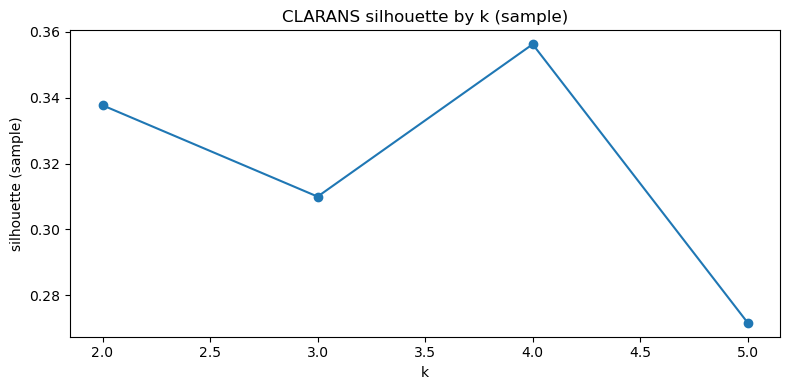

CLARANS k=4 cluster counts (sample): {0: 11534, 1: 33184, 2: 10958, 3: 14324}
✓ Saved CLARANS full-data labels to f:\DATA\results\unsupervised\clarans_labels.csv


In [10]:
# CLARANS (sampled, interrupt-safe) — fast alternative
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Helper: compute clustering quality metrics
def compute_metrics(X, labels):
    """Compute silhouette, davies-bouldin, and calinski-harabasz scores."""
    metrics = {}
    n_clusters = len(np.unique(labels))
    if n_clusters > 1 and n_clusters < len(X):
        try:
            metrics['silhouette'] = silhouette_score(X, labels)
        except Exception:
            metrics['silhouette'] = None
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
        except Exception:
            metrics['davies_bouldin'] = None
        try:
            metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        except Exception:
            metrics['calinski_harabasz'] = None
    return metrics

# Parameters: sampled CLARANS (bigger sample for better quality)
clarans_params = {
    'k_list': [2,3,4,5],
    'sample_size': 70000,   # increased sample size
    'numlocal': 3,          # a few more random restarts
    'maxneighbor': 75,      # slightly more neighbor checks per local search
    'metric': 'manhattan',  # distance metric for medoids
    'random_state': 42
}

# Helper: compute assignment cost and labels for a given medoid set

def _compute_cost_assign(X, medoids, metric='manhattan'):
    n, k = X.shape[0], len(medoids)
    D = np.empty((n, k), dtype=np.float32)
    M = X[medoids]
    if metric == 'manhattan':
        for j in range(k):
            D[:, j] = np.sum(np.abs(X - M[j]), axis=1)
    else:
        for j in range(k):
            diff = X - M[j]
            D[:, j] = np.sqrt(np.sum(diff*diff, axis=1))
    assign = np.argmin(D, axis=1)
    cost = float(np.sum(D[np.arange(n), assign]))
    return cost, assign

# CLARANS core: randomized medoid swaps with early stopping

def clarans(X, k, numlocal=2, maxneighbor=50, metric='manhattan', random_state=42, callback=None):
    rng = np.random.default_rng(random_state)
    best = None
    best_cost = np.inf
    history = []
    N = X.shape[0]
    all_idx = np.arange(N)
    for ilocal in range(numlocal):
        medoids = rng.choice(N, size=k, replace=False)
        current_cost, assign = _compute_cost_assign(X, medoids, metric)
        neighbor_cnt = 0
        while neighbor_cnt < maxneighbor:
            i = rng.integers(0, k)
            non_medoids = np.setdiff1d(all_idx, medoids, assume_unique=True)
            j = rng.choice(non_medoids)
            new_medoids = medoids.copy(); new_medoids[i] = j
            new_cost, new_assign = _compute_cost_assign(X, new_medoids, metric)
            if new_cost < current_cost:
                medoids = new_medoids
                current_cost = new_cost
                assign = new_assign
                neighbor_cnt = 0
                if callback:
                    callback({'ilocal': ilocal, 'cost': current_cost, 'medoids': medoids.tolist()})
            else:
                neighbor_cnt += 1
        # local minimum
        history.append({'ilocal': ilocal, 'cost': float(current_cost), 'medoids': medoids.tolist()})
        if current_cost < best_cost:
            best_cost = current_cost
            best = {'medoids': medoids.tolist(), 'assign': assign.tolist(), 'cost': float(current_cost)}
    return best, history

# Run sampled CLARANS across k values with interrupt safety
clarans_runs = {}
partial_path = Path(OUT_DIR / 'clarans_partial.json')
summary_path = Path(OUT_DIR / 'clarans_summary.json')

try:
    # Build sample
    N = Xs.shape[0]
    sample_n = min(clarans_params['sample_size'], N)
    rng = np.random.default_rng(clarans_params['random_state'])
    sel = rng.choice(N, size=sample_n, replace=False)
    Xs_sample = Xs[sel]

    for k in clarans_params['k_list']:
        print(f'[CLARANS] k={k} on sample n={sample_n} ...')
        # capture intermediate improvements
        improvements = []
        def _cb(info):
            improvements.append(info)
            # persist small checkpoint
            partial = clarans_runs.copy()
            partial[str(k)] = {'improvements': improvements}
            partial_path.write_text(json.dumps(partial, indent=2))
        best, hist = clarans(
            Xs_sample, k,
            numlocal=clarans_params['numlocal'],
            maxneighbor=clarans_params['maxneighbor'],
            metric=clarans_params['metric'],
            random_state=clarans_params['random_state'],
            callback=_cb
        )
        # compute metrics on sample
        labels = np.array(best['assign'])
        metrics = compute_metrics(Xs_sample, labels)
        clarans_runs[str(k)] = {
            'best': best,
            'history': hist,
            'metrics': metrics,
            'sample_n': int(sample_n),
            'sel_indices': sel.tolist()  # keep mapping to full Xs
        }
        # save partial after each k
        partial_path.write_text(json.dumps(clarans_runs, indent=2))
    # finalize
    summary_path.write_text(json.dumps({'params': clarans_params, 'runs': clarans_runs}, indent=2))
    print('✓ CLARANS summary saved:', summary_path)
except KeyboardInterrupt:
    print('⚠ Interrupted — partial results saved to', partial_path)

# Display quick silhouette vs k (sample)
k_vals = sorted([int(k) for k in clarans_runs.keys()])
sils = [clarans_runs[str(k)]['metrics'].get('silhouette') for k in k_vals]
plt.figure(figsize=(8,4))
plt.plot(k_vals, sils, marker='o')
plt.xlabel('k'); plt.ylabel('silhouette (sample)')
plt.title('CLARANS silhouette by k (sample)')
plt.tight_layout(); plt.show()

# Show cluster counts for selected k (sample)
if k_vals:
    k_sel = k_vals[np.nanargmax(sils)] if np.any([s is not None for s in sils]) else k_vals[0]
    labels = np.array(clarans_runs[str(k_sel)]['best']['assign'])
    counts = pd.Series(labels).value_counts().sort_index()
    print(f'CLARANS k={k_sel} cluster counts (sample):', counts.to_dict())

# NEW: Save CLARANS labels for full dataset using best k from sample
if k_vals:
    k_best = k_vals[np.nanargmax(sils)] if np.any([s is not None for s in sils]) else k_vals[0]
    run = clarans_runs[str(k_best)]
    medoid_sample_idx = np.array(run['best']['medoids'])  # indices within Xs_sample
    sel_indices = np.array(run['sel_indices'])            # mapping sample -> full
    medoid_full_idx = sel_indices[medoid_sample_idx]      # indices within full Xs
    # assign full data to nearest medoid
    _, full_assign = _compute_cost_assign(Xs, medoid_full_idx, metric=clarans_params['metric'])
    pd.DataFrame({'cluster_label': full_assign.astype(int)}).to_csv(OUT_DIR / 'clarans_labels.csv', index=False)
    print('✓ Saved CLARANS full-data labels to', OUT_DIR / 'clarans_labels.csv')

In [ ]:
# Interpretation: counts, feature ranges, and plots

import json

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path


# labels_kmeans = Path(OUT_DIR / 'kmeans_labels.csv')

labels_dbscan = Path(OUT_DIR / 'dbscan_labels.csv')

# labels_clarans = Path(OUT_DIR / 'clarans_labels.csv')


# Choose the latest available labels (prefer DBSCAN, then KMeans, then CLARANS)

label_df = None

if labels_dbscan.exists():

    label_df = pd.read_csv(labels_dbscan)

    chosen = 'dbscan'

# if labels_kmeans.exists():

#     label_df = pd.read_csv(labels_kmeans)

#     chosen = 'kmeans'

# elif labels_clarans.exists():

#     label_df = pd.read_csv(labels_clarans)

#     chosen = 'clarans'

else:

    print('No labels found under', OUT_DIR)


if label_df is not None:

    # Merge labels with original df indices (same order)

    df_labels = df.copy()

    df_labels['cluster_label'] = label_df['cluster_label'].values


    # Counts

    counts = df_labels['cluster_label'].value_counts().sort_index()

    print('Cluster counts:', counts.to_dict())


    # Per-feature min/mean/max per cluster

    stats = {}

    for cl in sorted(df_labels['cluster_label'].unique()):

        sub = df_labels[df_labels['cluster_label'] == cl]

        desc = sub[feature_cols].agg(['min','mean','max']).T

        stats[int(cl)] = {feat: {'min': float(desc.loc[feat,'min']), 'mean': float(desc.loc[feat,'mean']), 'max': float(desc.loc[feat,'max'])} for feat in feature_cols}

    Path(OUT_DIR / f'{chosen}_interpretation.json').write_text(json.dumps({'counts': {int(k): int(v) for k,v in counts.items()}, 'feature_stats': stats}, indent=2))


    # Save CSV of feature ranges

    rows = []

    for cl, feats in stats.items():

        for feat, vals in feats.items():

            rows.append({'cluster': cl, 'feature': feat, 'min': vals['min'], 'mean': vals['mean'], 'max': vals['max']})

    pd.DataFrame(rows).to_csv(OUT_DIR / f'{chosen}_feature_ranges.csv', index=False)


    # Plots: histogram of a few top-variance features per cluster

    top_feats = feature_cols[:6]

    for feat in top_feats:

        plt.figure(figsize=(8,4))

        for cl in sorted(df_labels['cluster_label'].unique()):

            sub = df_labels[df_labels['cluster_label'] == cl]

            plt.hist(sub[feat], bins=30, alpha=0.5, label=f'cluster {cl}')

        plt.title(f'{chosen} - {feat} distribution by cluster')

        plt.legend()

        plt.tight_layout()

        plt.show()


    # Scatter plot if coordinates exist

    if {'latitude','longitude'}.issubset(df_labels.columns):

        plt.figure(figsize=(8,6))

        for cl in sorted(df_labels['cluster_label'].unique()):

            sub = df_labels[df_labels['cluster_label'] == cl]

            plt.scatter(sub['longitude'], sub['latitude'], s=5, alpha=0.5, label=f'cluster {cl}')

        plt.xlabel('longitude')

        plt.ylabel('latitude')

        plt.title(f'{chosen} clusters on map')

        plt.legend(markerscale=4)

        plt.tight_layout()

        plt.show()


    print('Interpretation saved to:', OUT_DIR)

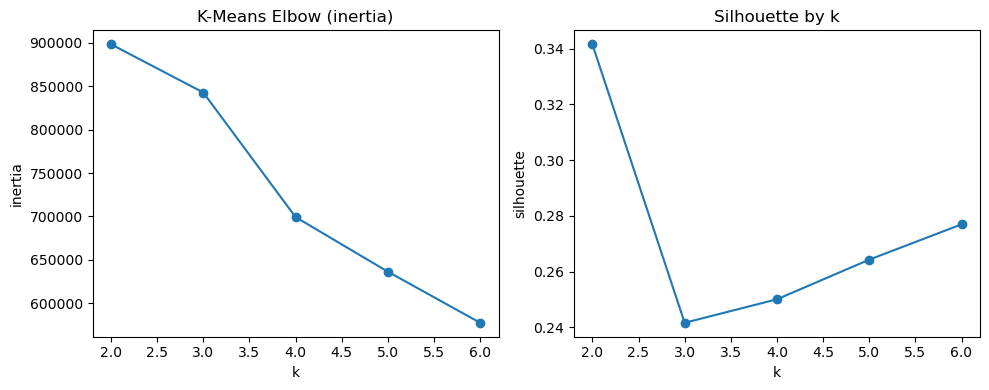

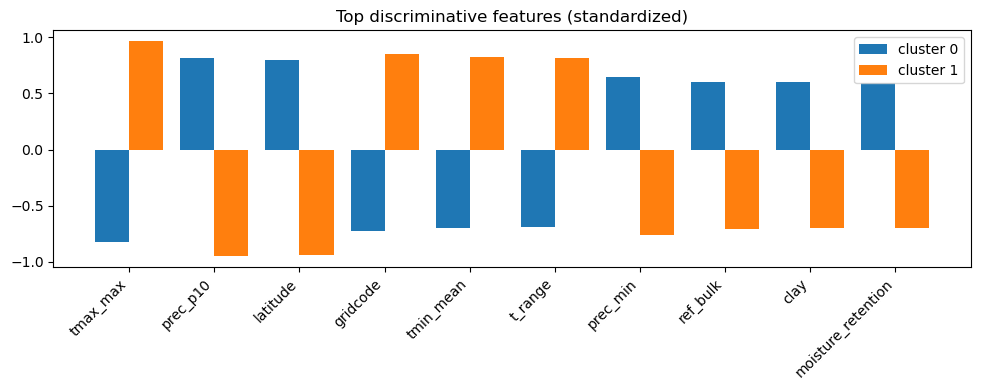

In [10]:
# K-Means diagnostics: elbow, silhouette by k, centroid profiles

import numpy as np
import matplotlib.pyplot as plt

# Build inertia from stored centroids and labels
inertia_by_k = {}
sil_by_k = {}
for k, res in results.items():
    centers = np.array(res['centroids'])
    lab = np.array(res['labels'])
    inertia = float(np.sum((Xs - centers[lab])**2))
    inertia_by_k[k] = inertia
    sil_by_k[k] = res['metrics'].get('silhouette')

ks_sorted = sorted(inertia_by_k.keys())
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks_sorted, [inertia_by_k[k] for k in ks_sorted], marker='o')
plt.title('K-Means Elbow (inertia)')
plt.xlabel('k'); plt.ylabel('inertia')

plt.subplot(1,2,2)
plt.plot(ks_sorted, [sil_by_k[k] if sil_by_k[k] is not None else np.nan for k in ks_sorted], marker='o')
plt.title('Silhouette by k')
plt.xlabel('k'); plt.ylabel('silhouette')
plt.tight_layout(); plt.show()

# Centroid profile (top-10 discriminative features)
centers = np.array(results[best_k]['centroids'])
if best_k == 2:
    diff = centers[0] - centers[1]
    top_idx = np.argsort(np.abs(diff))[::-1][:10]
    feats = [feature_cols[i] for i in top_idx]
    vals0 = centers[0, top_idx]
    vals1 = centers[1, top_idx]
    x = np.arange(len(feats))
    plt.figure(figsize=(10,4))
    plt.bar(x-0.2, vals0, width=0.4, label='cluster 0')
    plt.bar(x+0.2, vals1, width=0.4, label='cluster 1')
    plt.xticks(x, feats, rotation=45, ha='right')
    plt.title('Top discriminative features (standardized)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    # For k>2, plot variance across centroids to show most varying features
    var_across = centers.var(axis=0)
    top_idx = np.argsort(var_across)[::-1][:10]
    feats = [feature_cols[i] for i in top_idx]
    plt.figure(figsize=(10,4))
    for ci in range(best_k):
        plt.plot(feats, centers[ci, top_idx], marker='o', label=f'cluster {ci}')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top varying features across centroids (standardized)')
    plt.legend(); plt.tight_layout(); plt.show()

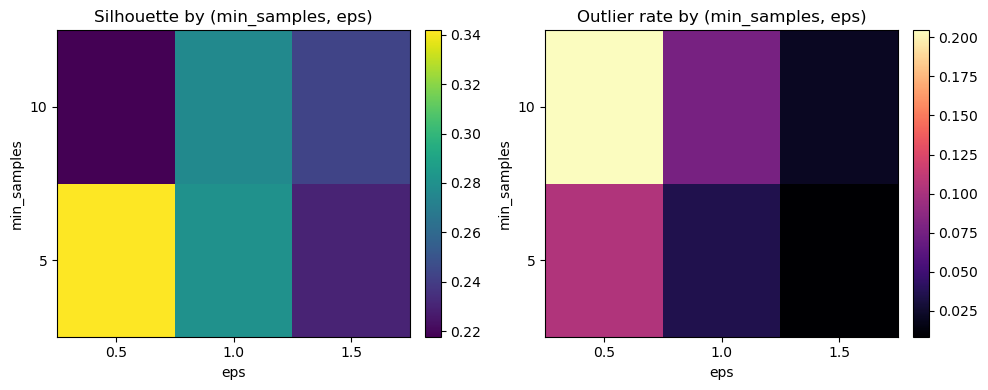

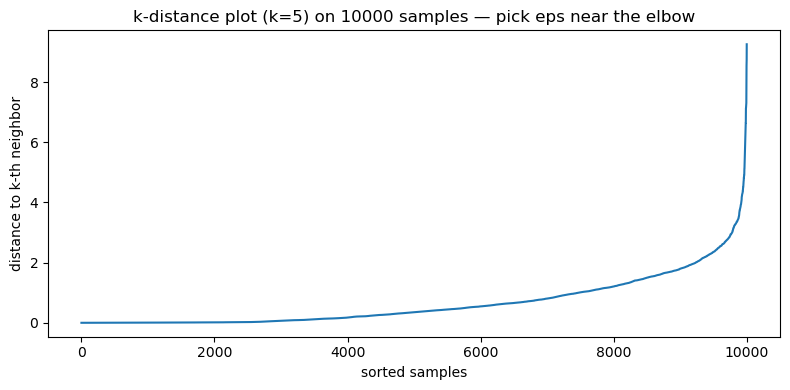

In [15]:
# DBSCAN diagnostics: heatmap and k-distance plot (sampled)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Build grids for visualization
unique_eps = sorted(set([r['eps'] for r in runs]))
unique_ms = sorted(set([r['min_samples'] for r in runs]))
mat_sil = np.full((len(unique_ms), len(unique_eps)), np.nan)
mat_out = np.full((len(unique_ms), len(unique_eps)), np.nan)
for r in runs:
    i = unique_ms.index(r['min_samples'])
    j = unique_eps.index(r['eps'])
    mat_sil[i, j] = r['metrics'].get('silhouette') if r['metrics'].get('silhouette') is not None else np.nan
    mat_out[i, j] = r['outliers'] / len(Xs)

fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(mat_sil, aspect='auto', cmap='viridis', origin='lower')
axs[0].set_xticks(range(len(unique_eps))); axs[0].set_xticklabels(unique_eps)
axs[0].set_yticks(range(len(unique_ms))); axs[0].set_yticklabels(unique_ms)
axs[0].set_title('Silhouette by (min_samples, eps)')
axs[0].set_xlabel('eps'); axs[0].set_ylabel('min_samples')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(mat_out, aspect='auto', cmap='magma', origin='lower')
axs[1].set_xticks(range(len(unique_eps))); axs[1].set_xticklabels(unique_eps)
axs[1].set_yticks(range(len(unique_ms))); axs[1].set_yticklabels(unique_ms)
axs[1].set_title('Outlier rate by (min_samples, eps)')
axs[1].set_xlabel('eps'); axs[1].set_ylabel('min_samples')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# k-distance plot (sample up to 10k points)
sample_n = min(10000, len(Xs))
rng = np.random.RandomState(42)
sel = rng.choice(len(Xs), size=sample_n, replace=False)
X_sample = Xs[sel]
knn = 5
nbrs = NearestNeighbors(n_neighbors=knn, metric='manhattan').fit(X_sample)
distances, _ = nbrs.kneighbors(X_sample)
kdist = np.sort(distances[:, -1])
plt.figure(figsize=(8,4))
plt.plot(kdist)
plt.title(f'k-distance plot (k={knn}) on {sample_n} samples — pick eps near the elbow')
plt.xlabel('sorted samples'); plt.ylabel('distance to k-th neighbor')
plt.tight_layout(); plt.show()

In [16]:
# Cluster vs Fire Alignment: ARI/AMI and per-cluster fire rates

import pandas as pd

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score


labels_kmeans = Path(OUT_DIR / 'kmeans_labels.csv')

# labels_dbscan = Path(OUT_DIR / 'dbscan_labels.csv')

# labels_clarans = Path(OUT_DIR / 'clarans_labels.csv')


label_df = None; chosen = None

# if labels_dbscan.exists():

#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'

if labels_kmeans.exists():

    label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'

# elif labels_clarans.exists():

#     label_df = pd.read_csv(labels_clarans); chosen = 'clarans'


if label_df is not None and 'fire' in df.columns:

    df_align = df.copy()

    df_align['cluster_label'] = label_df['cluster_label'].values

    # Metrics only for reporting; do not use to pick features in unsupervised

    ari = adjusted_rand_score(df_align['fire'], df_align['cluster_label'])

    ami = adjusted_mutual_info_score(df_align['fire'], df_align['cluster_label'])

    hom = homogeneity_score(df_align['fire'], df_align['cluster_label'])

    comp = completeness_score(df_align['fire'], df_align['cluster_label'])

    print({'method': chosen, 'ARI': ari, 'AMI': ami, 'homogeneity': hom, 'completeness': comp})

    # Per-cluster fire rates

    rates = df_align.groupby('cluster_label')['fire'].mean().to_dict()

    counts = df_align['cluster_label'].value_counts().sort_index().to_dict()

    print({'counts': counts, 'fire_rate_per_cluster': rates})

else:

    print('Fire label not available or no labels found; skipping alignment metrics.')

{'method': 'kmeans', 'ARI': 0.09035100927919479, 'AMI': np.float64(0.08946550734354702), 'homogeneity': np.float64(0.10641945882378943), 'completeness': np.float64(0.07718719701762182)}
{'counts': {0: 38380, 1: 32670}, 'fire_rate_per_cluster': {0: 0.08157894736842106, 1: 0.33911845730027546}}


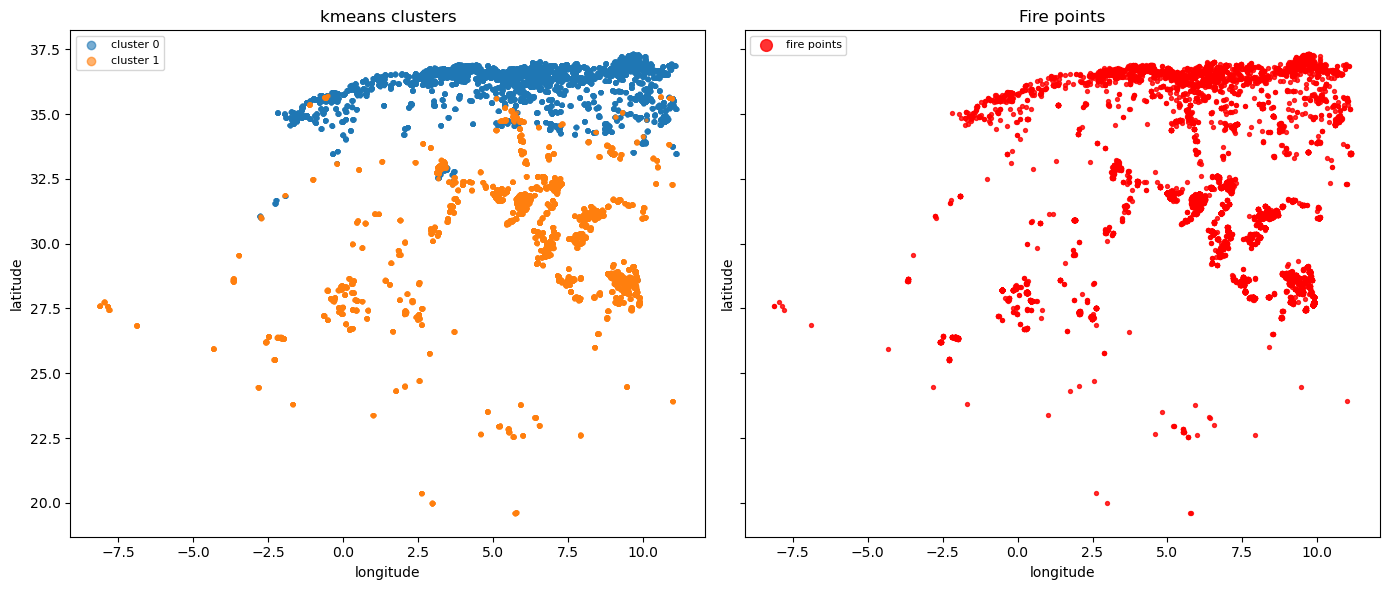

In [14]:
# Map views: side-by-side clusters and fire points

import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path


labels_kmeans = Path(OUT_DIR / 'kmeans_labels.csv')

# labels_dbscan = Path(OUT_DIR / 'dbscan_labels.csv')

# labels_clarans = Path(OUT_DIR / 'clarans_labels.csv')


label_df = None; chosen = None

# if labels_dbscan.exists():

#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'

if labels_kmeans.exists():

    label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'

# elif labels_clarans.exists():

#     label_df = pd.read_csv(labels_clarans); chosen = 'clarans'


if label_df is not None and {'latitude','longitude','fire'}.issubset(df.columns):

    df_map = df.copy()

    df_map['cluster_label'] = label_df['cluster_label'].values

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    # Left: clusters

    for cl in sorted(df_map['cluster_label'].unique()):

        sub = df_map[df_map['cluster_label'] == cl]

        axs[0].scatter(sub['longitude'], sub['latitude'], s=4, alpha=0.6, label=f'cluster {cl}')

    axs[0].set_xlabel('longitude'); axs[0].set_ylabel('latitude')

    axs[0].set_title(f'{chosen} clusters')

    axs[0].legend(markerscale=3, loc='best', fontsize=8)

    # Right: fire points only

    fires = df_map[df_map['fire'] == 1]

    axs[1].scatter(fires['longitude'], fires['latitude'], s=8, c='red', alpha=0.8, label='fire points')

    axs[1].set_xlabel('longitude'); axs[1].set_ylabel('latitude')

    axs[1].set_title('Fire points')

    axs[1].legend(markerscale=3, loc='best', fontsize=8)

    plt.tight_layout(); plt.show()

else:

    print('Missing required columns (latitude/longitude/fire) or labels; skipping side-by-side maps.')

,k,silhouette,cost,sample_n
0,2,0.335157,225427.765625,20000
1,3,0.313964,194094.312500,20000
2,4,0.341590,166135.859375,20000
3,5,0.281803,150375.093750,20000


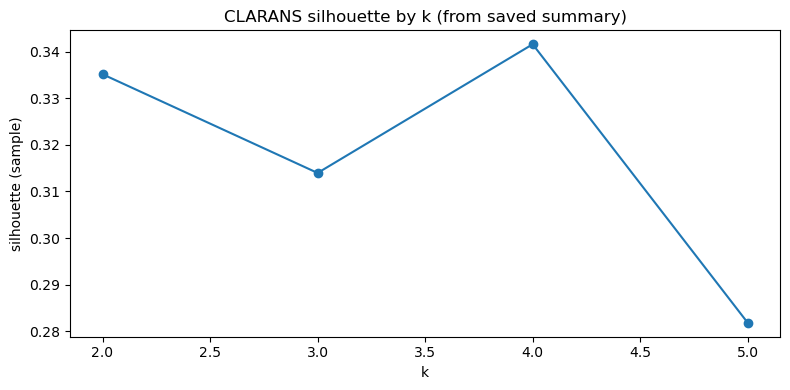

Best k: 4 | silhouette: 0.34158984936425857 | sample_n: 20000
Half-good verdict: YES | tiny clusters: 0


In [8]:
# CLARANS Result Check — summarize saved outputs
from pathlib import Path
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt

clarans_sum_path = Path(OUT_DIR / 'clarans_summary.json')
clarans_partial_path = Path(OUT_DIR / 'clarans_partial.json')

def _load_json(p):
    try:
        return json.loads(p.read_text()) if p.exists() else None
    except Exception as e:
        print('Failed to read', p, e); return None

summary = _load_json(clarans_sum_path)
partial = _load_json(clarans_partial_path)

if summary and 'runs' in summary:
    runs = summary['runs']
    # table of k, silhouette, cost, sample_n
    rows = []
    for k_str, r in runs.items():
        k = int(k_str)
        sil = r.get('metrics', {}).get('silhouette')
        cost = r.get('best', {}).get('cost')
        sample_n = r.get('sample_n')
        rows.append({'k': k, 'silhouette': sil, 'cost': cost, 'sample_n': sample_n})
    dfk = pd.DataFrame(rows).sort_values('k')
    display(dfk)
    # plot silhouette vs k
    plt.figure(figsize=(8,4))
    plt.plot(dfk['k'], dfk['silhouette'], marker='o')
    plt.xlabel('k'); plt.ylabel('silhouette (sample)')
    plt.title('CLARANS silhouette by k (from saved summary)')
    plt.tight_layout(); plt.show()
    # quick verdict
    best_row = dfk.loc[dfk['silhouette'].idxmax()] if dfk['silhouette'].notna().any() else dfk.iloc[0]
    print('Best k:', int(best_row['k']), '| silhouette:', best_row['silhouette'], '| sample_n:', int(best_row['sample_n']))
    # heuristic: half-good if silhouette >= 0.1 and no extremely tiny clusters
    k_best = int(best_row['k'])
    labels = np.array(runs[str(k_best)]['best']['assign'])
    counts = pd.Series(labels).value_counts().sort_index()
    tiny = (counts < max(5, 0.005*len(labels))).sum()
    verdict = (best_row['silhouette'] is not None and best_row['silhouette'] >= 0.1 and tiny == 0)
    print('Half-good verdict:', 'YES' if verdict else 'NO', '| tiny clusters:', int(tiny))
elif partial:
    print('No summary yet; showing partial improvements keys:')
    print(list(partial.keys()))
else:
    print('No CLARANS outputs found in', OUT_DIR)

In [ ]:
# K-Medoids (sklearn-extra, sampled) — compare with CLARANS
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Try to import KMedoids from scikit-learn-extra
try:
    from sklearn_extra.cluster import KMedoids
except Exception as e:
    print('scikit-learn-extra (KMedoids) not available. Install with:')
    print('pip install scikit-learn-extra')
    raise

# Helper: compute metrics
def _km_metrics(X, labels):
    m = {}
    try:
        if len(set(labels)) > 1 and len(set(labels)) < len(labels):
            m['silhouette'] = float(silhouette_score(X, labels))
    except Exception:
        m['silhouette'] = None
    try:
        if len(set(labels)) > 1:
            m['davies_bouldin'] = float(davies_bouldin_score(X, labels))
            m['calinski_harabasz'] = float(calinski_harabasz_score(X, labels))
    except Exception:
        m['davies_bouldin'] = None
        m['calinski_harabasz'] = None
    return m

# Sample size
# sample_n = min(10000, len(Xs))
sample_n= 70000
rng = np.random.default_rng(42)
sel = rng.choice(len(Xs), size=sample_n, replace=False)
Xs_sample = Xs[sel]

ks = [2,3,4,5]
results_km_sample = {}
for k in ks:
    # Use 'alternate' to avoid full NxN distance matrix; smart init
    km = KMedoids(
        n_clusters=k,
        metric='manhattan',
        method='alternate',
        init='k-medoids++',
        max_iter=300,
        random_state=42
    )
    labels_sample = km.fit_predict(Xs_sample)
    metrics = _km_metrics(Xs_sample, labels_sample)
    results_km_sample[k] = {
        'medoid_indices_sample': km.medoid_indices_.tolist(),
        'labels_sample': list(map(int, labels_sample)),
        'metrics': metrics
    }

# choose best k by silhouette on sample, fallback by min davies_bouldin
best_k_km = None
best_sil_km = -1
for k, res in results_km_sample.items():
    sil = res['metrics'].get('silhouette')
    if sil is not None and sil > best_sil_km:
        best_sil_km = sil
        best_k_km = k
if best_k_km is None:
    best_k_km = min(results_km_sample.keys(), key=lambda kk: results_km_sample[kk]['metrics'].get('davies_bouldin', np.inf))

# Map sample medoids to full dataset indices
medoid_sample_idx = np.array(results_km_sample[best_k_km]['medoid_indices_sample'])
medoid_full_idx = sel[medoid_sample_idx]

# Assign full data to nearest medoid using manhattan distance
k = len(medoid_full_idx)
M = Xs[medoid_full_idx]
D = np.empty((len(Xs), k), dtype=np.float32)
for j in range(k):
    D[:, j] = np.sum(np.abs(Xs - M[j]), axis=1)
full_assign = np.argmin(D, axis=1).astype(int)

# Save full-data labels and summary
pd.DataFrame({'cluster_label': full_assign}).to_csv(OUT_DIR / 'kmedoids_labels.csv', index=False)
(Path(OUT_DIR / 'kmedoids_summary.json')).write_text(json.dumps({
    'best_k': int(best_k_km),
    'sample_n': int(sample_n),
    'sel_indices': sel.tolist(),
    'medoid_full_indices': medoid_full_idx.tolist(),
    'results_sample': results_km_sample
}, indent=2))
print('K-Medoids (sampled) best k:', best_k_km, '| silhouette (sample):', results_km_sample[best_k_km]['metrics'].get('silhouette'))

K-Medoids (sampled) best k: 2 | silhouette (sample): 0.3360625298819924


In [ ]:
# CLARANS vs K-Medoids — label comparison and alignment
import pandas as pd
from pathlib import Path
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score

clarans_labels_path = Path(OUT_DIR / 'clarans_labels.csv')
kmedoids_labels_path = Path(OUT_DIR / 'kmedoids_labels.csv')

if clarans_labels_path.exists() and kmedoids_labels_path.exists():
    lab_cla = pd.read_csv(clarans_labels_path)['cluster_label'].values
    lab_km = pd.read_csv(kmedoids_labels_path)['cluster_label'].values
    if len(lab_cla) == len(lab_km):
        ari = adjusted_rand_score(lab_cla, lab_km)
        ami = adjusted_mutual_info_score(lab_cla, lab_km)
        hom = homogeneity_score(lab_cla, lab_km)
        comp = completeness_score(lab_cla, lab_km)
        print({'ARI(CLARANS,KMedoids)': ari, 'AMI': ami, 'homogeneity': hom, 'completeness': comp})
        # simple counts comparison
        print('Counts CLARANS:', dict(pd.Series(lab_cla).value_counts().sort_index()))
        print('Counts KMedoids:', dict(pd.Series(lab_km).value_counts().sort_index()))
    else:
        print('Label length mismatch between CLARANS and K-Medoids.')
else:
    print('Missing clarans_labels.csv or kmedoids_labels.csv; run both cells first.')